In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

# Read in

In [2]:
!ls /home/kk837/rfs/rfs-teichlab-nfs-iCNyzSAaucw/jc2226/heart_team_data/xenium/20241113__133901__JK_HEA5K_Hs_heart_vessels

output-XETG00155__0038587__C194-HEA-0-FFPE-1__20241113__134112
output-XETG00155__0038587__Hst45-HEA-0-FFPE-1__20241113__134112
output-XETG00155__0038587__Hst60-HEA-0-FFPE-1__20241113__134112
output-XETG00155__0038592__AH13-HEA-36-FFPE-1__20241113__134112
output-XETG00155__0038592__AH14-HEA-29-FFPE-2__20241113__134112
output-XETG00155__0038592__AH14-HEA-36-FFPE-1__20241113__134112


In [3]:
sample_id = 'C194-HEA-0-FFPE-1'
out_dir = f'/home/kk837/rfs/rfs-teichlab-nfs-iCNyzSAaucw/jc2226/heart_team_data/xenium/20241113__133901__JK_HEA5K_Hs_heart_vessels/output-XETG00155__0038587__{sample_id}__20241113__134112'

adata = sc.read_10x_h5(
    filename=os.path.join(out_dir,"cell_feature_matrix.h5")
)
print(adata.X.data[:5])
adata

[5. 1. 1. 2. 2.]


AnnData object with n_obs × n_vars = 146232 × 5001
    var: 'gene_ids', 'feature_types', 'genome'

In [4]:
# add obs
df = pd.read_csv(
    os.path.join(out_dir,"cells.csv.gz")
)
df.set_index(adata.obs_names, inplace=True)
adata.obs = df.copy()
adata.obs.head()

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,nucleus_count,segmentation_method
aaaafiob-1,aaaafiob-1,782.026245,1025.860474,754,0,0,0,0,0,754,73.017659,51.116877,1,Segmented by boundary stain (ATP1A1+CD45+E-Cad...
aaaajopp-1,aaaajopp-1,784.114746,1034.308350,145,0,0,0,0,0,145,34.589689,20.771876,1,Segmented by boundary stain (ATP1A1+CD45+E-Cad...
aaaanald-1,aaaanald-1,791.200500,1028.298462,569,0,0,0,0,0,569,56.580783,32.512501,1,Segmented by boundary stain (ATP1A1+CD45+E-Cad...
aaabdjka-1,aaabdjka-1,819.555664,1032.847168,659,0,0,0,1,0,660,57.709690,38.744064,1,Segmented by boundary stain (ATP1A1+CD45+E-Cad...
aaabglmg-1,aaabglmg-1,819.384583,1007.732910,83,0,0,0,0,0,83,58.116096,34.544533,1,Segmented by boundary stain (ATP1A1+CD45+E-Cad...


In [5]:
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [6]:
adata

AnnData object with n_obs × n_vars = 146232 × 5001
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

/tmp/ipykernel_364135/27570213.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata,color=['total_counts'],cmap='RdPu',spot_size=20,vmax='p95')


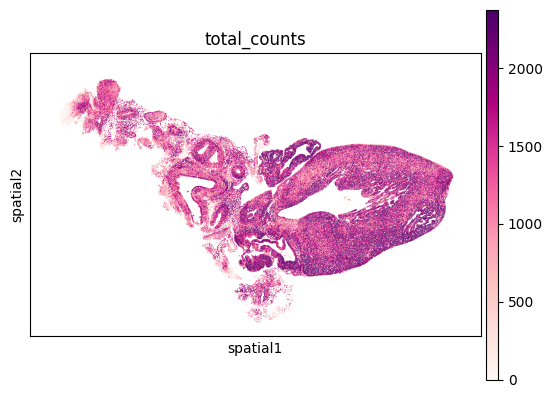

In [7]:
sc.pl.spatial(adata,color=['total_counts'],cmap='RdPu',spot_size=20,vmax='p95')

In [8]:
adata.obs['segmentation_method'].value_counts()

segmentation_method
Segmented by interior stain (18S)                       114599
Segmented by boundary stain (ATP1A1+CD45+E-Cadherin)     30718
Segmented by nucleus expansion of 5.0µm                    915
Name: count, dtype: int64

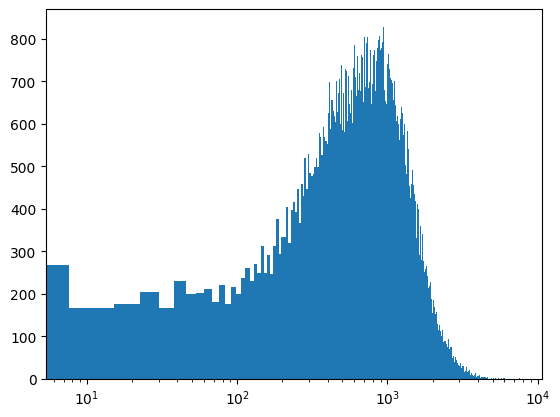

In [9]:
plt.hist(adata.obs.total_counts, bins=1000)
# plt.xlim(0,500)
plt.xscale('log')
plt.show()

# Calculate quality control metrics

In [10]:
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

In [11]:
# The percentage of control probes and control codewords can be calculated from adata.obs
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")

Negative DNA probe count % : 0.0008306279191532507
Negative decoding count % : 0.004514935328449433


<Axes: title={'center': 'Nucleus ratio'}, ylabel='Count'>

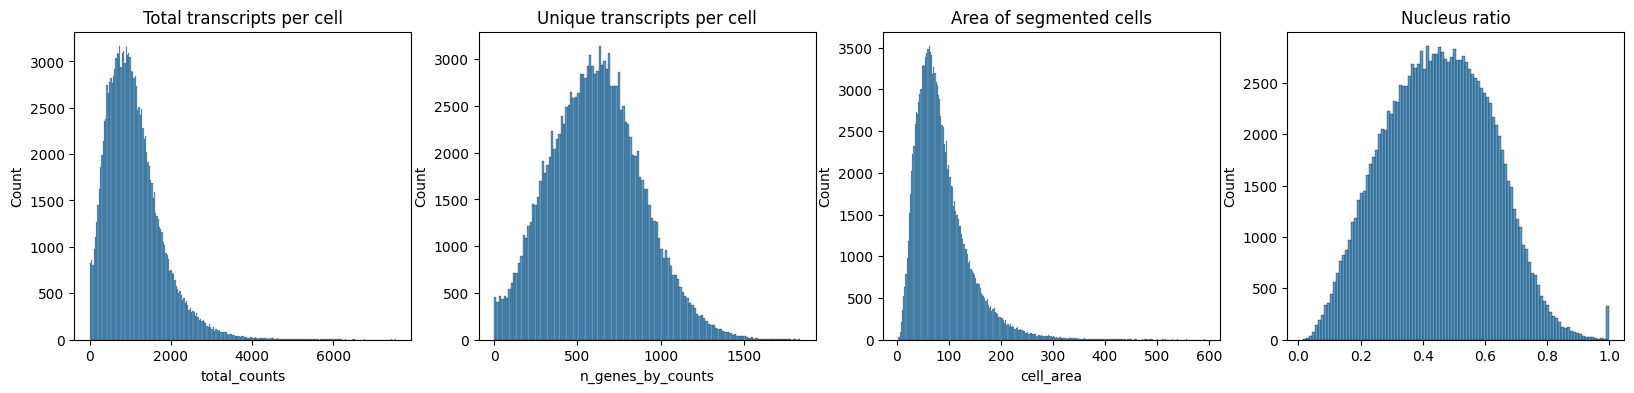

In [12]:
# Next we plot the distribution of total transcripts per cell, unique transcripts per cell, area of segmented cells and the ratio of nuclei area to their cells
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


axs[2].set_title("Area of segmented cells")
sns.histplot(
    adata.obs["cell_area"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("Nucleus ratio")
sns.histplot(
    adata.obs["nucleus_area"] / adata.obs["cell_area"],
    kde=False,
    ax=axs[3],
)

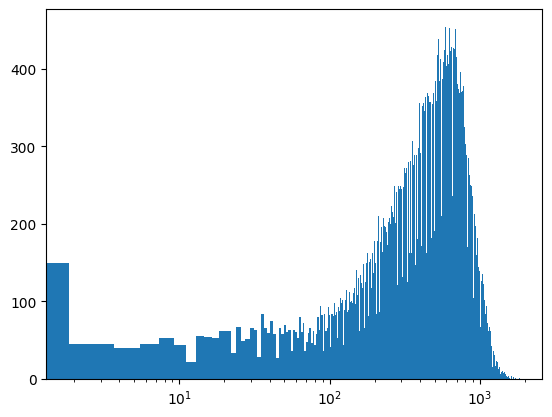

In [13]:
plt.hist(adata.obs.n_genes_by_counts, bins=1000)
# plt.xlim(0,500)
plt.xscale('log')
plt.show()

# Filtering out low-count cells

In [14]:
sc.pp.filter_cells(adata,min_counts=50)
sc.pp.filter_cells(adata,min_genes=10)

# Save

In [16]:
adata.write(f'/home/kk837/rds/rds-teichlab-C9woKbOCf2Y/kk837/Foetal/anndata_objects/Xenium/{sample_id}_5K_filtered_raw.h5ad')

In [17]:
sample_id

'C194-HEA-0-FFPE-1'

In [19]:
adata

AnnData object with n_obs × n_vars = 144916 × 5001
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'